In [199]:
import numpy as np
import librosa
import os
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torchaudio
import torchaudio.transforms as transforms
import pandas as pd
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import tarfile

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract Dataset

In [ ]:
def extract_tarfile(file_path, destination_path):
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(destination_path)

# Example usage
tar_file_path = '/content/drive/MyDrive/svarah.tar'
extract_to_directory = 'svarah'

extract_tarfile(tar_file_path, extract_to_directory)

Visualize Data

In [202]:
csv = pd.read_csv("/content/svarah/svarah/meta_speaker_stats.csv")
csv.head()

,audio_filepath,duration,text,gender,age-group,primary_language,native_place_state,native_place_district,highest_qualification,job_category,occupation_domain
0,audio/281474976895472_f74_chunk_0.wav,0.098000,Up,Female,30-45,Urdu,Karnataka,Bangalore Urban,Post Graduate,Part Time,Education and Research
1,audio/281474976899770_f1412_chunk_0.wav,0.126625,Skip,Female,30-45,Odia,Odisha,Cuttack,Graduate,Other,Healthcare (Medical &amp; Pharma)
2,audio/281474976903881_f1632_chunk_0.wav,0.135313,Up,Female,45-60,Nepali,Assam,Kamrup,Graduate,Full Time,Education and Research
3,audio/281474976895472_f2996_chunk_0.wav,0.156438,Up,Female,30-45,Urdu,Karnataka,Bangalore Urban,Post Graduate,Part Time,Education and Research
4,audio/281474976899939_f968_chunk_0.wav,0.158750,Skip,Male,30-45,Maithili,Bihar,Samastipur,Doctoral (PhD) or higher level,Full Time,Education and Research


In [203]:
audio_csv = pd.DataFrame(csv.loc[:, 'audio_filepath'])

In [204]:
def extract_speaker_id(filepath):
    parts = filepath.split('/')
    speaker_id = parts[1].split('_')[0]
    return speaker_id

# Apply the function to all rows of the DataFrame
audio_csv['speaker_id'] = audio_csv['audio_filepath'].apply(extract_speaker_id)
speaker_ids = audio_csv['speaker_id'].unique()

In [205]:
audio_csv['speaker_id'] = audio_csv['audio_filepath'].str.split('_').str[0].str.split('/').str[1]

# Group by speaker ID and count occurrences
speaker_counts = audio_csv.groupby('speaker_id').size()

# Filter speaker IDs with more than 15 samples
subsampled_sid = speaker_counts[speaker_counts > 20].index.tolist()

print("Speaker IDs with more than 20 samples:")
print(subsampled_sid)

# Filter DataFrame to keep only rows with matching speaker IDs
sub_df = audio_csv[audio_csv['speaker_id'].isin(subsampled_sid)]

Speaker IDs with more than 20 samples:
['281474976883943', '281474976884044', '281474976884082', '281474976884085', '281474976884478', '281474976885796', '281474976885801', '281474976888866', '281474976888873', '281474976888909', '281474976888911', '281474976888914', '281474976888917', '281474976888919', '281474976889220', '281474976894268', '281474976894271', '281474976894273', '281474976894795', '281474976897307', '281474976897459', '281474976900596', '281474976900603']


In [206]:
mapping = {val: idx + 1 for idx, val in enumerate(set(subsampled_sid))}

# Audio PreProcessing

In [207]:
import numpy as np
from scipy import signal

import numpy as np
import librosa
from scipy import signal

def preprocess_audio_mfcc(wav_file, sr=16000, n_fft=48, hop_length=256, n_mels=12):
  # Load audio using librosa (assumes WAV format)
  wav, _ = librosa.load(wav_file, sr=sr)

  # Frame division with overlap
  frames = librosa.util.frame(wav, frame_length=n_fft, hop_length=hop_length)

  # Apply window function (Hamming window by default)
  window = librosa.filters.get_window('hann', n_fft)
  window = window.reshape(-1, 1)  # Reshape to have one column
  windowed_frames = frames * window

  # FFT transformation
  fft_frames = np.fft.fft(windowed_frames, axis=1)
  # Compute MFCC features (using log-magnitude spectrum for stability)
  mfcc_features = librosa.feature.mfcc(y=np.abs(fft_frames), sr=sr, n_mels=n_mels, n_fft=n_fft)

  mfcc_features = np.mean(mfcc_features, axis=2)
  mfcc_features = np.mean(mfcc_features, axis=0)

  # Chroma_stft mean and variance
  chroma_mean = np.mean(librosa.feature.chroma_stft(y=wav, sr=sr), axis=1)
  chroma_var = np.var(librosa.feature.chroma_stft(y=wav, sr=sr), axis=1)

  # RMS mean and variance
  rms_mean = np.mean(librosa.feature.rms(y=wav))
  rms_var = np.var(librosa.feature.rms(y=wav))

  # Concatenate all features
  features = np.concatenate([mfcc_features , chroma_mean, chroma_var, [rms_mean], [rms_var]])

  return features

def extract_features(speaker_id=None, file=None):
  features = preprocess_audio_mfcc(file)

  filename = os.path.basename(file)

  df = pd.DataFrame(columns=['speaker_id'] + ['filename'] + [f'feature_{i}' for i in range(1, len(features)+1)])

  # Add data to DataFrame
  df.loc[0, 'speaker_id'] = speaker_id
  df.loc[0, 'filename'] = filename
  df.loc[0, 'feature_1':] = features

  return df

In [208]:
df_list = []

for i, sid in enumerate(subsampled_sid):
  audio_df = pd.DataFrame()
  speaker_df = sub_df[sub_df['speaker_id'] == sid]

  speaker_id = mapping.get(sid)

  # Iterate over filtered DataFrame and extract features from each audio file
  for index, row in speaker_df.iterrows():
    audio_file = os.path.join("/content/svarah/svarah", row['audio_filepath'])
    features = extract_features(speaker_id, audio_file)
    audio_df = pd.concat([audio_df, features], ignore_index=True)

  print(f"{i+1}/{len(subsampled_sid)} Extracted")
  df_list.append(audio_df)

1/23 Extracted
2/23 Extracted
3/23 Extracted
4/23 Extracted
5/23 Extracted
6/23 Extracted
7/23 Extracted
8/23 Extracted
9/23 Extracted
10/23 Extracted
11/23 Extracted
12/23 Extracted
13/23 Extracted
14/23 Extracted
15/23 Extracted


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=48 is too large for input signal of length=30
  warnings.warn(


16/23 Extracted
17/23 Extracted
18/23 Extracted
19/23 Extracted
20/23 Extracted
21/23 Extracted
22/23 Extracted
23/23 Extracted


## Split the dataset

In [209]:
from sklearn.model_selection import train_test_split

trained_dfs = []
test_dfs = []

for df in df_list:
  train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
  train_df = pd.DataFrame(train)
  test_df = pd.DataFrame(test)

  trained_dfs.append(train_df)
  test_dfs.append(test_df)

## Train the model

In [210]:
import pandas as pd
from sklearn.mixture import GaussianMixture
import joblib

os.makedirs("/content/models", exist_ok=True)

save_dir = "/content/models"
# Function to train GMM for each speaker
def train_gmm_for_speakers(dfs, subsampled_sid):
    for df in trained_dfs:
        speaker_id = df['speaker_id'][0]
        mfcc_features = df.drop(columns=['filename', 'speaker_id'])  # Assuming 'speaker_id' is a column to drop

        # print(mfcc_features)

        # Train GMM
        gmm = GaussianMixture(n_components=10)  # Adjust the number of components as needed
        gmm.fit(mfcc_features)

        # Save trained GMM model
        model_filename = f'{save_dir}/{speaker_id}_gmm.pkl'
        joblib.dump(gmm, model_filename)
        print(f"GMM model saved for speaker ID {speaker_id} as {model_filename}")


# Train GMM for each speaker and save the models
train_gmm_for_speakers(trained_dfs, subsampled_sid)

GMM model saved for speaker ID 16 as /content/models/16_gmm.pkl
GMM model saved for speaker ID 17 as /content/models/17_gmm.pkl
GMM model saved for speaker ID 9 as /content/models/9_gmm.pkl
GMM model saved for speaker ID 4 as /content/models/4_gmm.pkl
GMM model saved for speaker ID 18 as /content/models/18_gmm.pkl
GMM model saved for speaker ID 23 as /content/models/23_gmm.pkl
GMM model saved for speaker ID 15 as /content/models/15_gmm.pkl
GMM model saved for speaker ID 22 as /content/models/22_gmm.pkl
GMM model saved for speaker ID 6 as /content/models/6_gmm.pkl
GMM model saved for speaker ID 7 as /content/models/7_gmm.pkl
GMM model saved for speaker ID 21 as /content/models/21_gmm.pkl
GMM model saved for speaker ID 20 as /content/models/20_gmm.pkl
GMM model saved for speaker ID 19 as /content/models/19_gmm.pkl
GMM model saved for speaker ID 12 as /content/models/12_gmm.pkl
GMM model saved for speaker ID 13 as /content/models/13_gmm.pkl
GMM model saved for speaker ID 10 as /content/mo

## Evaluate

In [211]:
speakers_models = os.listdir("/content/models/")

In [217]:
fars = []
frrs = []

model_ids = []
eers = []

threshold = -38000000

for i, gdf in enumerate(test_dfs):
  frr, far = 0, 0

  genuine_speaker_id = gdf['speaker_id'].iloc[0]
  genuine_features = gdf.drop(columns=['filename', 'speaker_id'])

  model_ids.append(genuine_speaker_id)
  # print(genuine_speaker_id)
  for model in speakers_models:
    if str(genuine_speaker_id) in model:
      gmm = model
      break

  # Check for false rejection rate
  gmm = joblib.load(os.path.join("/content/models", gmm))

  # print(genuine_features.iloc[0])
  score = gmm.score_samples(genuine_features).mean()

  if score < threshold:
    frr += 1

  for j, idf in enumerate(test_dfs):
    if i != j:  # Skip the index of the first loop item
      imp_speaker_id = idf['speaker_id']
      imp_features = idf.drop(columns=['filename', 'speaker_id'])

       # print(genuine_features.iloc[0])
      iscore = gmm.score_samples(imp_features).mean()

      if iscore < threshold:
        far += 1

  far = far / (len(test_dfs) - 1)
  eer = (far + frr) / 2

  eers.append(eer)

  print(f"EER for {model}: {eer:0.4f}%")

EER for 16_gmm.pkl: 0.5000%
EER for 17_gmm.pkl: 0.2727%
EER for 19_gmm.pkl: 0.6591%
EER for 4_gmm.pkl: 0.4545%
EER for 18_gmm.pkl: 0.0000%
EER for 23_gmm.pkl: 0.3636%
EER for 15_gmm.pkl: 0.3636%
EER for 22_gmm.pkl: 0.3409%
EER for 6_gmm.pkl: 0.0909%
EER for 17_gmm.pkl: 0.7500%
EER for 21_gmm.pkl: 0.0909%
EER for 20_gmm.pkl: 0.1136%
EER for 19_gmm.pkl: 0.1818%
EER for 12_gmm.pkl: 0.1591%
EER for 13_gmm.pkl: 0.4545%
EER for 10_gmm.pkl: 0.2727%
EER for 11_gmm.pkl: 0.2955%
EER for 15_gmm.pkl: 0.8409%
EER for 13_gmm.pkl: 0.9318%
EER for 18_gmm.pkl: 0.0000%
EER for 14_gmm.pkl: 0.4318%
EER for 12_gmm.pkl: 0.1591%
EER for 15_gmm.pkl: 0.8409%


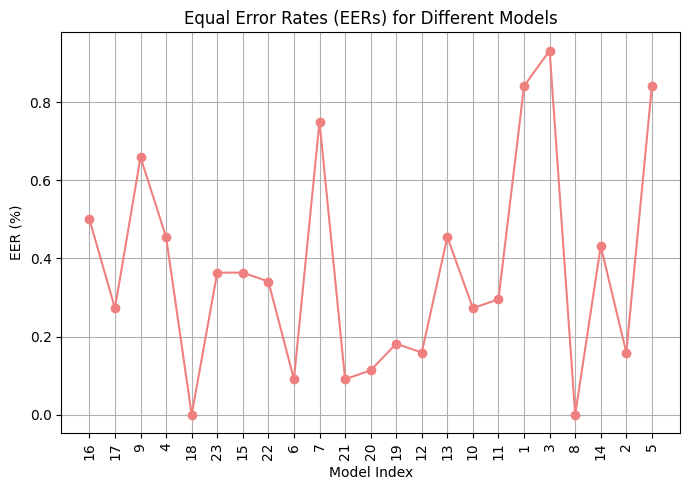

In [224]:
import re
import matplotlib.pyplot as plt

indices = np.arange(len(model_ids))
# Create a bar plot
plt.figure(figsize=(7, 5))
plt.plot(indices, eers, marker='o', color='lightcoral', linestyle='-')
plt.xlabel('Model Index')
plt.ylabel('EER (%)')
plt.title('Equal Error Rates (EERs) for Different Models')
plt.xticks(indices, model_ids, rotation=90)  # Set model names as x-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.grid(True)  # Add grid lines for better readability
plt.show()


## Authentication

# MAP

In [255]:
def map_estimation(gmm_models, features):
    log_likelihood_speakers = np.zeros(len(gmm_models))
    model_names = []

    # Calculate log likelihoods for each speaker model
    for i, gmm in enumerate(gmm_models):

        if gmm.endswith(".pkl"):
          model_names.append(gmm)
          gmm = joblib.load(os.path.join("/content/models", gmm))
          scores = gmm.score(features)
          # print(scores)
          log_likelihood_speakers[i] = scores.sum()

    # Compute prior probabilities (assuming uniform priors)
    prior_probabilities = np.ones(len(gmm_models)) / len(gmm_models)

    # Compute posterior probabilities using Bayes' theorem
    log_posterior_probabilities = log_likelihood_speakers + np.log(prior_probabilities)

    # Get the predicted speaker ID with the maximum posterior probability
    predicted_index = np.argmax(log_posterior_probabilities)
    max_posterior_probability = log_posterior_probabilities[predicted_index]
    predicted_speaker = model_names[predicted_index].split("_")[0]

    return predicted_speaker


def predidc(filename):
  auth_audio_file = os.path.join("/content/svarah/svarah/audio", file_name)
  # auth_audio, _ = torchaudio.load(auth_audio_file)
  auth_ext_feat = extract_features(file=auth_audio_file)
  auth_ext_feat = auth_ext_feat.drop(columns=['filename', 'speaker_id'])
  prediction_speaker = map_estimation(speakers_models, auth_ext_feat)

  map = file_name.split("_")[0]

  return [prediction_speaker, mapping.get(map)]

file_name = "281474976883943_f2231_chunk_2.wav"
result = predidc(file_name)
print(f"Predicted Speaker ID: {result[0]}\nOriginal Speaker ID: {result[1]}")

file_name = "281474976888866_f2195_chunk_16.wav"
result = predidc(file_name)
print(f"Predicted Speaker ID: {result[0]}\nOriginal Speaker ID: {result[1]}")

Predicted Speaker ID: 16
Original Speaker ID: 16
Predicted Speaker ID: 22
Original Speaker ID: 22


## Enrollement

In [214]:
enroll_df = audio_csv[audio_csv['speaker_id']=="281474976895472"]
enroll_df.head()

,audio_filepath,speaker_id
0,audio/281474976895472_f74_chunk_0.wav,281474976895472
3,audio/281474976895472_f2996_chunk_0.wav,281474976895472


In [215]:
enroll_id = max(mapping.values()) + 1

audio_df = pd.DataFrame()

for index, row in enroll_df.iterrows():
  audio_file = os.path.join("/content/svarah/svarah", row['audio_filepath'])

  features = extract_features(enroll_id, audio_file)
  audio_df = pd.concat([audio_df, features], ignore_index=True)

enroll_features = audio_df.drop(columns=['filename', 'speaker_id'])
# Train Gaussian Mixture Model (GMM)
num_components = 2 # Example number of components
gmm = GaussianMixture(n_components=num_components)
gmm.fit(enroll_features)

# Save the trained GMM model
joblib.dump(gmm, f'/content/models/{enroll_id}_gmm_model.pkl')

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=48 is too large for input signal of length=6
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1568
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=48 is too large for input signal of length=10
  warnings.warn(


['/content/models/24_gmm_model.pkl']